We first import the necessary packages.

In [1]:
import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from model import ANODE
from utils import train_reverse
from flax.training import train_state

# Enable 64 bit for more precision
jax.config.update("jax_enable_x64", True)

We now create the NODE architecture. Note that the NODE is a special case of the ANODE which has 0 augmentation dimensions.

In [2]:
rng_key = jax.random.PRNGKey(0)

model = ANODE(
    num_hidden=16,
    sample_dims=1,
    aug_dims=0,
    n_blocks=4,
)


rng_key, init_key, init_sample_key = jax.random.split(rng_key, 3)
init_samples, _ = model.get_prior_samples(init_sample_key, n_samples=1)
params = model.init(init_key, 0.0, init_samples)

We now define the unnormalized target density and log density.

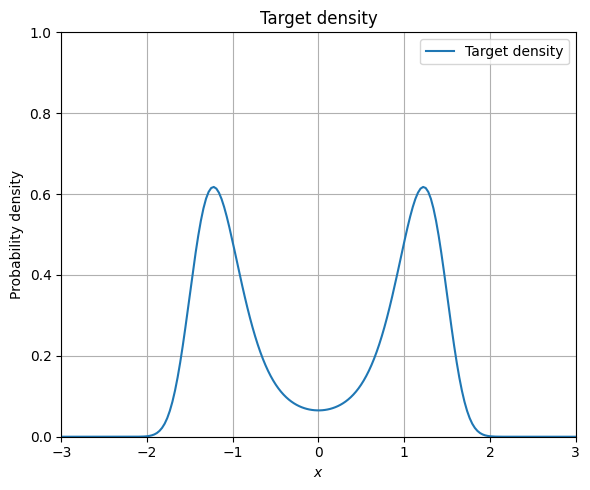

In [3]:
def p(x):
    return jnp.exp(3 * x**2 - x**4)

def log_p(x):
    return 3 * x**2 - x**4

# Visualize the target distribution (normalization constant is approxiamtely 15.36, obtained trough numerical integration)
x_linspace = jnp.linspace(-3, 3, 200)
y = p(x_linspace) / 15.36



plt.figure(figsize=(6,5))
plt.plot(x_linspace, y, label="Target density")
plt.xlabel(r"$x$")
plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.ylim(0, 1)
plt.title("Target density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


We can now train our network.

In [4]:
learning_rate = 1e-4
optimizer = optax.adam(learning_rate=learning_rate)

# Create the training state
train_state = train_state.TrainState.create(
    apply_fn=model.sample,
    params=params,
    tx=optimizer,
)

# Train the model using the reverse KL divergence for 1000 steps on a batch size of 128 samples
rng_key, train_key = jax.random.split(rng_key)
train_state, train_metrics = train_reverse(train_state, train_key, log_p, num_epochs=1_000, batch_size=128)

Epoch 0: Loss: -1.4045, ESS: 0.0314 ± 0.0282, ACCEPT_RATE: 0.4549 ± 0.0144, INTEGRATE_ERROR: 0.0834 ± 0.0993
Epoch 1: Loss: -1.2290
Epoch 2: Loss: -1.5213
Epoch 3: Loss: -0.9969
Epoch 4: Loss: -1.9101
Epoch 5: Loss: -1.6240
Epoch 6: Loss: -1.4843
Epoch 7: Loss: -1.0017
Epoch 8: Loss: -1.7918
Epoch 9: Loss: -1.4515
Epoch 10: Loss: -1.2188
Epoch 11: Loss: -1.6361
Epoch 12: Loss: -1.3596
Epoch 13: Loss: -1.5547
Epoch 14: Loss: -1.1183
Epoch 15: Loss: -1.3206
Epoch 16: Loss: -1.0655
Epoch 17: Loss: -1.8550
Epoch 18: Loss: -1.7928
Epoch 19: Loss: -1.7166
Epoch 20: Loss: -1.7205
Epoch 21: Loss: -1.4101
Epoch 22: Loss: -1.1627
Epoch 23: Loss: -0.9921
Epoch 24: Loss: -1.8256
Epoch 25: Loss: -1.9627
Epoch 26: Loss: -0.8047
Epoch 27: Loss: -1.6704
Epoch 28: Loss: -1.9048
Epoch 29: Loss: -1.8625
Epoch 30: Loss: -1.9419
Epoch 31: Loss: -1.8815
Epoch 32: Loss: -2.0330
Epoch 33: Loss: -1.3617
Epoch 34: Loss: -1.7647
Epoch 35: Loss: -1.7070
Epoch 36: Loss: -1.7864
Epoch 37: Loss: -1.9198
Epoch 38: Lo

We now visualize the learned distribution.

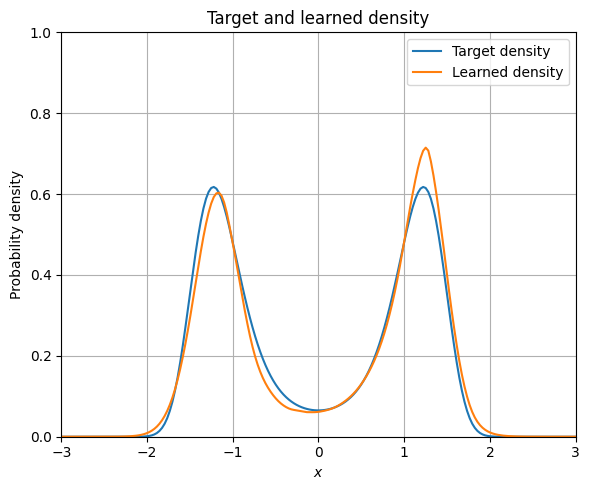

In [5]:
x_linspace = jnp.linspace(-3, 3, 200)
y = p(x_linspace) / 15.36


samples, y_learned = model.get_logp(train_state.params, x_linspace.reshape(-1, 1), rng_key)



plt.figure(figsize=(6,5))
plt.plot(x_linspace, y, label="Target density")
plt.plot(x_linspace, jnp.exp(y_learned), label="Learned density")
plt.xlabel(r"$x$")
plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.title("Target and learned density")
plt.tight_layout()
plt.show()